In [1]:
import numpy as np
import pandas as pd
import tracktor as tr
import cv2
import sys
import scipy.signal
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

## Global parameters
This cell (below) enlists user-defined parameters

In [2]:
# colours is a vector of BGR values which are used to identify individuals in the video
# since we only have one individual, the program will only use the first element from this array i.e. (0,0,255) - red
# number of elements in colours should be greater than n_inds (THIS IS NECESSARY FOR VISUALISATION ONLY)
n_inds = 1
colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0)]

# this is the block_size and offset used for adaptive thresholding (block_size should always be odd)
# these values are critical for tracking performance
block_size = 81
offset = 38

# the scaling parameter can be used to speed up tracking if video resolution is too high (use value 0-1)
scaling = 1.0

# minimum area and maximum area occupied by the animal in number of pixels
# this parameter is used to get rid of other objects in view that might be hard to threshold out but are differently sized
min_area = 1000
max_area = 10000

# mot determines whether the tracker is being used in noisy conditions to track a single object or for multi-object
# using this will enable k-means clustering to force n_inds number of animals
mot = False

# name of source video and paths
video = 'fish_video'
input_vidpath = '/mnt/ssd1/Documents/Vivek/tracktor/videos/' + video + '.mp4'
output_vidpath = '/mnt/ssd1/Documents/Vivek/tracktor/output/' + video + '_tracked.mp4'
output_filepath = '/mnt/ssd1/Documents/Vivek/tracktor/output/' + video + '_tracked.csv'
codec = 'DIVX' # try other codecs if the default doesn't work ('DIVX', 'avc1', 'XVID') note: this list is non-exhaustive

The cell below runs the tracking code

In [3]:
## Open video
cap = cv2.VideoCapture(input_vidpath)
if cap.isOpened() == False:
    sys.exit('Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file')

## Video writer class to output video with contour and centroid of tracked object(s)
# make sure the frame size matches size of array 'final'
fourcc = cv2.VideoWriter_fourcc(*codec)
output_framesize = (int(cap.read()[1].shape[1]*scaling),int(cap.read()[1].shape[0]*scaling))
out = cv2.VideoWriter(filename = output_vidpath, fourcc = fourcc, fps = 30.0, frameSize = output_framesize, isColor = True)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

last = 0
df = []

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    this = cap.get(1)
    if ret == True:
        frame = cv2.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv2.INTER_LINEAR)
        thresh = tr.colour_to_thresh(frame, block_size, offset)
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
        final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, mot, this)
        
        # Create output dataframe
        for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1]])
        
        # Display the resulting frame
        out.write(final)
        cv2.imshow('frame', final)
        if cv2.waitKey(1) == 27 or meas_now[0][0] < 20 or meas_now[0][0] > cap.get(3) - 20 or meas_now[0][1] < 20 or meas_now[0][1] > cap.get(4) - 20:
            break
            
    if last >= this:
        break
    
    last = this

## Write positions to file
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y'])
df.to_csv(output_filepath, sep=',')

## When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


-1

## Summary statistics
The cells below provide functions to perform basic summary statistics - in this case, distance moved between successive frames, cumulative distance within a time-window, velocity and acceleration.

In [3]:
df = pd.read_csv(output_filepath)
df.head()

,Unnamed: 0,frame,pos_x,pos_y
0,0,3.0,1528.266545,330.394003
1,1,4.0,1528.014137,330.746537
2,2,5.0,1527.535179,331.382478
3,3,6.0,1527.484960,331.537206
4,4,7.0,1527.365566,331.500347


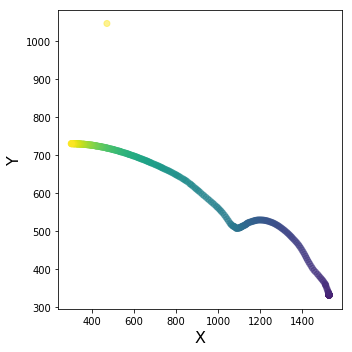

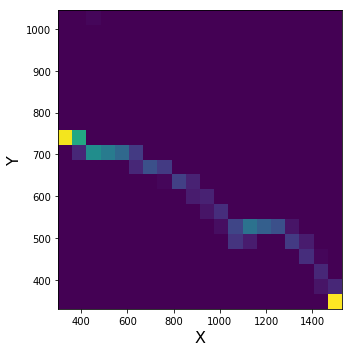

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(df['pos_x'], df['pos_y'], c=df['frame'], alpha=0.5)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex1_fig1a.eps', format='eps', dpi=300)
plt.show()

plt.figure(figsize=(5,5))
plt.hist2d(df['pos_x'], df['pos_y'], bins=20)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex1_fig1b.eps', format='eps', dpi=300)
plt.show()

In [6]:
## Parameters like speed and acceleration can be very noisy. Small noise in positional data is amplified as we take the
## derivative to get speed and acceleration. We therefore smooth this data to obtain reliable values and eliminate noise.

# the smoothing window parameter determines the extent of smoothing (this parameter must be odd)
smoothing_window = 11

## Fill in the parameters below if you'd like movement measures to be converted from pixels and frames to 
## real-world measures (cms and secs)

# Frame-rate (fps or frames per second) of recorded video to calculate time
fps = 1000

# Pixels per cm to in the recorded video to calculate distances
pxpercm = 78 * scaling

In [7]:
dx = df['pos_x'] - df['pos_x'].shift(n_inds)
dy = df['pos_y'] - df['pos_y'].shift(n_inds)
d2x = dx - dx.shift(1)
d2y = dy - dy.shift(1)
df['speed'] = np.sqrt(dx**2 + dy**2)
df['smoothed_speed'] = scipy.signal.savgol_filter(df['speed'], smoothing_window, 1)
df['accn'] = np.sqrt(d2x**2 + d2y**2)
df['smoothed_accn'] = scipy.signal.savgol_filter(df['accn'], smoothing_window, 1)
df['cum_dist'] = df['smoothed_speed'].cumsum()
df.head()

,Unnamed: 0,frame,pos_x,pos_y,speed,smoothed_speed,accn,smoothed_accn,cum_dist
0,0,3.0,1528.266545,330.394003,NaN,NaN,NaN,NaN,NaN
1,1,4.0,1528.014137,330.746537,0.433579,NaN,NaN,NaN,NaN
2,2,5.0,1527.535179,331.382478,0.796129,NaN,0.362828,NaN,NaN
3,3,6.0,1527.484960,331.537206,0.162674,NaN,0.644501,NaN,NaN
4,4,7.0,1527.365566,331.500347,0.124954,NaN,0.203693,NaN,NaN


In [8]:
def cumul_dist(start_fr, end_fr):
    if start_fr != 1:
        cumul_dist = df['cum_dist'][df['frame'] == end_fr].values[0] - df['cum_dist'][df['frame'] == start_fr].values[0]
    else:
        cumul_dist = df['cum_dist'][df['frame'] == end_fr].values[0]
    return cumul_dist

In [9]:
cumul_dist(150,200)

324.57402181382463

In [10]:
df['time'] = df['frame'] / fps
df['speed'] = df['speed'] * fps / pxpercm
df['smoothed_speed'] = df['smoothed_speed'] * fps / pxpercm
df['accn'] = df['accn'] * fps * fps / pxpercm
df['smoothed_accn'] = df['smoothed_accn'] * fps * fps / pxpercm
df['cum_dist'] = df['cum_dist'] / pxpercm
df.head()

,Unnamed: 0,frame,pos_x,pos_y,speed,smoothed_speed,accn,smoothed_accn,cum_dist,time
0,0,3.0,1528.266545,330.394003,NaN,NaN,NaN,NaN,NaN,0.003
1,1,4.0,1528.014137,330.746537,5.558699,NaN,NaN,NaN,NaN,0.004
2,2,5.0,1527.535179,331.382478,10.206779,NaN,4651.635494,NaN,NaN,0.005
3,3,6.0,1527.484960,331.537206,2.085563,NaN,8262.838993,NaN,NaN,0.006
4,4,7.0,1527.365566,331.500347,1.601980,NaN,2611.453893,NaN,NaN,0.007


In [11]:
cumul_dist(140,170) / pxpercm

0.018344433361225577

In [12]:
np.nanmax(df['smoothed_speed']), np.nanmax(df['smoothed_accn'])

(1467.7072731350565, 1467663.9080077177)

In [13]:
## We now remove any outliers that remain post smoothing
## Here we want to conservative and not eliminate any relavant points as outliers. We therefore choose a high 'm' value
## in the reject_outliers functions. The best approach is to visually compare smoothed data with the original data
index = tr.reject_outliers(df['smoothed_speed'], m = 6)
index = np.array(index[0])

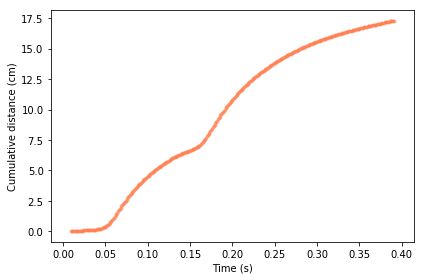

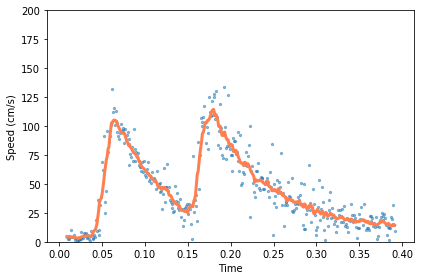

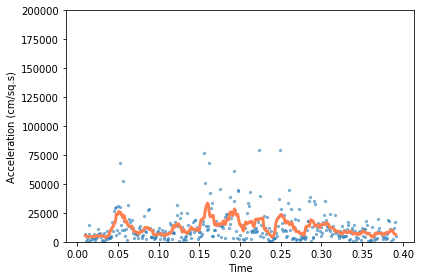

In [16]:
plt.scatter(df['time'][index], df['cum_dist'][index], c='#FF7F50', s=8, alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Cumulative distance (cm)')
plt.tight_layout()
plt.savefig('imgs/ex1_fig2a.eps', format='eps', dpi=300)
plt.show()

plt.scatter(df['time'][index], df['speed'][index], s=5, alpha=0.5)
plt.plot(df['time'][index], df['smoothed_speed'][index], c='#FF7F50', lw=3)
plt.ylim(0,200)
plt.xlabel('Time')
plt.ylabel('Speed (cm/s)')
plt.tight_layout()
plt.savefig('imgs/ex1_fig2b.eps', format='eps', dpi=300)
plt.show()

plt.scatter(df['time'][index], df['accn'][index], s=5, alpha=0.5)
plt.plot(df['time'][index], df['smoothed_accn'][index], c='#FF7F50', lw=3)
plt.ylim(0,200000)
plt.xlabel('Time')
plt.ylabel('Acceleration (cm/sq.s)')
plt.tight_layout()
plt.savefig('imgs/ex1_fig2c.eps', format='eps', dpi=300)
plt.show()